# Introduction

In this exercise we will learn the basic usage of two widely used machine learning frameworks.
 * TMVA
 * sklearn

We use a dataset from the Belle experiment. The Belle experiment was located in Tsukuba, Japan at the KEKB asymmetric electron-positron collider, which operated at a center of mass energy of 10.58 GeV.
The decay D0 -> K- pi+ (pi0 -> gamma gamma) was reconstructed and simple cuts on the particle identification information and the kinematics were applied to reduce the combinatorical background.
A mass-constrained vertex fit of the pi0 was performed, and an unconstrained vertex fit of the D0.

Two datasets are provided:
 * csc_mc.root contains Monte Carlo simulated events
 * csc_data.root contains Detector Data

In [1]:
! rm csc_mc.root csc_data.root
! wget http://ekpwww.ekp.kit.edu/~tkeck/csc_mc.root http://ekpwww.ekp.kit.edu/~tkeck/csc_data.root

--2017-07-27 15:55:23--  http://ekpwww.ekp.kit.edu/~tkeck/csc_mc.root
Resolving ekpwww.ekp.kit.edu... 129.13.101.178
Connecting to ekpwww.ekp.kit.edu|129.13.101.178|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32880821 (31M)
Saving to: “csc_mc.root”

100%[======================================>] 32,880,821  25.5M/s   in 1.2s    

2017-07-27 15:55:25 (25.5 MB/s) - “csc_mc.root” saved [32880821/32880821]

--2017-07-27 15:55:25--  http://ekpwww.ekp.kit.edu/~tkeck/csc_data.root
Reusing existing connection to ekpwww.ekp.kit.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 28276441 (27M)
Saving to: “csc_data.root”

100%[======================================>] 28,276,441  34.8M/s   in 0.8s    

2017-07-27 15:55:26 (34.8 MB/s) - “csc_data.root” saved [28276441/28276441]

FINISHED --2017-07-27 15:55:26--
Downloaded: 2 files, 58M in 2.0s (29.1 MB/s)


## The SciPy stack

**Python-based ecosystem of open-source software for mathematics, science, and engineering**

 * **NumPy** N-dimensional array package and data format used in SciPy
 * **Matplotlib** Plotting and data visualization
 * **SciPy** Scientific computing: Integration, Optimization, Statistics, ...
 * **SKLearn** Simple and efficient tools for data mining and data analysis
 * **Pandas** Data structures & data analysis
 
You can find out more here https://www.scipy.org/

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Convert root to a pandas.DataFrame
Converting your root file to a pandas.DataFrame (and vice versa) is easy.
You can use the root_numpy package

In [44]:
import root_numpy
mc = pd.DataFrame.from_records(root_numpy.root2array('csc_mc.root'))
mc = mc.sample(frac=1)
train, test = mc[:len(mc)//2], mc[len(mc)//2:]
data = pd.DataFrame.from_records(root_numpy.root2array('csc_data.root'))

## Detailed Description of all Features

The overall signal fraction in the provided sample is 2.9%.
Signal (correctly reconstructed D0 candidates) and background candidates (combinatorical background and background
from other decays) can be distinguished by the **isSignal** feature, where 1 indicates signal and 0 indicates background.


The following additional features are provided:

- **index** index (number from 0 to ~200 000)
- **Kinmeatic features of the D0**
    * **p** total momentum
    * **pt** transverse momentum = sqrt(px*px+py*py)
    * **pz** z component of the momentum
    * **phi** angle between the pt and the x-axis
    * **M** invariant mass
- **Vertex fit features of the D0**
    * **chiProb** p-value of the decay vertex fit
    * **dr** fitted transverse distance of the decay vertex
    * **dz** fitted distance in z of the decay certex
    * **dphi** angle between dr and the x-axis
- **Pairwise quantities of the daughters**
    * **daughterAngleIJ** angle between the momentum of the Ith and Jth daughter, where I,J in {0,1,2}
    * **invariantMassIJ** pairwise invariant mass of the Ith and Jth daughter, where I,J in {0,1,2}
- **Kinematic features of the daughters**
    * **pI** total momentum of the Ith daughter, where I in {0,1,2}
    * **ptI** transverse momentum of the Ith daughter, where I in {0,1,2}
    * **pzI** z component of the momentum of the Ith daughter, where I in {0,1,2}
    * **phiI** angle between the pt and the x-axis of the Ith daughter, where I in {0,1,2}
- **Track fit features of the daughters**
    * **chiProbI** p-value of the track fit of the Ith daughter, where I in {0,1}
    * **drI** fitted transverse distance of the POCA of the Ith daughter, where I in {0,1}
    * **dzI** fitted distance in z to the POCA of the Ith daughter, where I in {0,1}
    * **dphiI** angle between dr and the x-axis of the Ith daughter, where I in {0,1}
- **Particle identification information**
    * **KidI** kaon likelihood of the Ith daughter, where I in {0,1}
    * **piidI** pion likelihood of the Ith daughter, where I in {0,1}
- **Information about the photons used for the pi0**
    * **M2** the invariant mass of the two photons
    * **chiProb2** p-value of the mass-constrained vertex fit
    * **EI** Energy of the Ith photon, where I in {0,1}
    * **highestEI** The hit with the highest Energy of the Ith photon, where I in {0,1}
    * **hitsI** The number of hits of the Ith photon in the ECK, where I in {0,1}
    * **ratioI** ratio between the 9 cells and 25 cells around the seed of the photon cluster, for the Ith photon, where I in {0,1}
  * **distanceI** distance of the cluster to the closest track in the CDC of the Ith photon, where I in {0,1}


All momenta and energies are given in **GEV**, and all distances in **cm**.

### Glossary

 * **POCA** point of closest approach to the beam axis
 * **CDC** central drift chamber


## Getting an Overview over the data
Understanding the data is usually an important and time-consuming step during data analysis. Detecting errors due to data collection, preprocessing the data to cast it in a usable format for the task at hand, check for differences between simulated and real data, choosing sensible pre-cuts to minimize the required computing resources and systematic uncertainties. We will keep this part very short here.

In the next cell you see a simple plotting function, which you can use if you are not familiar with the SciPy stack

In [66]:
def simple_plot(variable, mc=mc, data=data, normed=False):
    config = dict(bins=50, normed=normed)
    data[variable].hist(label='Data', color='grey', **config)
    config.update(lw=2, histtype='step')
    mask = mc['isSignal'] == 1
    mc.loc[mask, variable].hist(label='Monte Carlo (Signal)', color='red', weights=mc.loc[mask, 'w'],  **config)
    mc.loc[~mask, variable].hist(label='Monte Carlo (Background)', color='blue', weights=mc.loc[~mask, 'w'], **config)
    plt.ylabel('Normalised number of events')
    plt.xlabel(variable)
    plt.legend(bbox_to_anchor=(0.9, 1.35))
    plt.show()

** Invariant Mass of the D0 mesons **

The filled grey histogram shows the data, the expectation from Monte Carlo simulation is shown in red for signal and blue for background. You can clearly see that the Monte Carlo simulation predicted too much background.

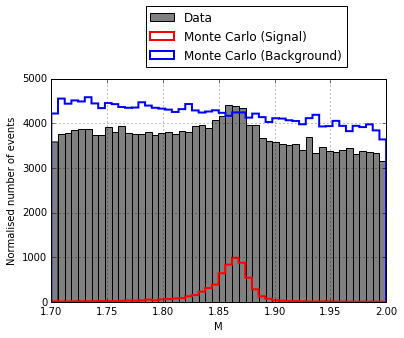

In [67]:
simple_plot('M')

### Exercise 1

Look at the distributions for some of the variables and familiarize yourself with the dataset.
You can use the provided simple_plot function and the names of the features described above e.g.
p1 for the total momentum of the Kaon, invariantMass01 for the invariant mass of the Kaon-pion system, chiProb2 for the chi2 probability of the mass-constrained vertex fit of the pi0.

In [6]:
# Your plotting code goes here

## SKLearn

Scikit-Learn (aka SKlearn) is a machine learning library build on top of the scipy project, which aims to provide a full data analysis stack for science written in python. Hence SKLearn integrates well with famous python libraries like numpy, pandas and matplotlib. You can find more information on these frameworks here http://scikit-learn.org and here https://www.scipy.org.

We train a few of the methods we discussed in the lecture. Our goal is to improve the signal-to-noise ratio in our data.
You can use the evaluate_classifier function to judge the performance of the classifier if you are not familiar
with the SciPy stack, or write your own evaluation function.
The function plots the ROC curve and the invariant mass distribution with the maximal signal-to-noise ratio.

In [75]:
features = ['p', 'pt', 'pz', 'phi', 'chiProb', 'dr', 'dz', 'dphi', # D0
            'Kid0', 'chiProb0', 'dr0', 'dz0', # K-
            'Kid1', 'chiProb1', 'dr1', 'dz1', # pi+
            "p0", "p1", "p2", "daughterAngle01", "daughterAngle02",
            'E0', 'width0', 'highestE0', 'hits0', 'ratio0', 'distance0', # first gamma
            'E1', 'width1', 'highestE1', 'hits1', 'ratio1', 'distance1', # second gamma
            'chiProb2' # pi0
           ]
target = ['isSignal']

import sklearn.metrics
import scipy.optimize

def signal_to_noise(cut, p, df):
    "Calculates the signal-to-noise ratio for a given cut on the probability p for the dataset df"
    s = df[(p > cut[0]) & (df.M > 1.8) & (df.M < 1.9)]
    return -s.loc[s.isSignal == 1, 'w'].sum() / s['w'].sum()**0.5

def evaluate_classifier(clf, train=train, test=test, data=data):
    p_train = clf.predict_proba(train[features])[:, 1]
    p_test = clf.predict_proba(test[features])[:, 1]
    p_data = clf.predict_proba(data[features])[:, 1]
    plt.plot([0,1], [0,1], 'k--', color='black')
    fpr, tpr, _ = sklearn.metrics.roc_curve(train[target], p_train, sample_weight=train['w'])
    auc = sklearn.metrics.roc_auc_score(train[target], p_train, sample_weight=train['w'])
    plt.plot(fpr, tpr, color='blue', label='Train (AUC = {:.2f})'.format(auc))
    fpr, tpr, _ = sklearn.metrics.roc_curve(test[target], p_test, sample_weight=test['w'])   
    auc = sklearn.metrics.roc_auc_score(test[target], p_test, sample_weight=test['w'])
    plt.plot(fpr, tpr, color='green', label='Test (AUC = {:.2f})'.format(auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    cut = scipy.optimize.minimize(signal_to_noise, [0.01], args=(p_train, train), method='Nelder-Mead').x[0]
    simple_plot('M', mc=pd.concat([train[p_train > cut], test[p_test > cut]]), data=data[p_data > cut])
    return("Signal To Noise {:.2f} {:.2f}".format(signal_to_noise([0.0], p_train, train),
                                                  signal_to_noise([cut], p_train, train)))

## Linear Discriminant Analysis

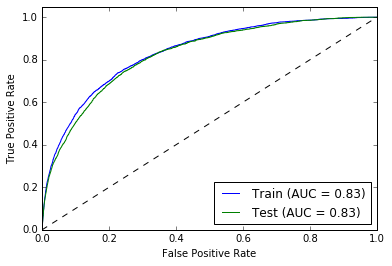

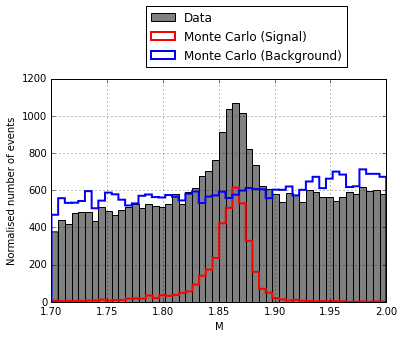

'Signal To Noise -14.86 -22.43'

In [76]:
import sklearn.discriminant_analysis
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(train[features], train[target].values.ravel())
evaluate_classifier(lda)

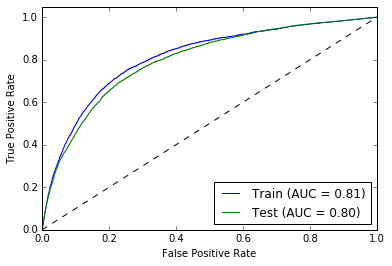

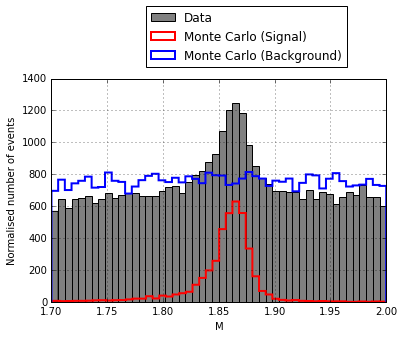

'Signal To Noise -14.86 -21.22'

In [77]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(train[features], train[target].values.ravel())
evaluate_classifier(qda)

## Boosted Decision Tree

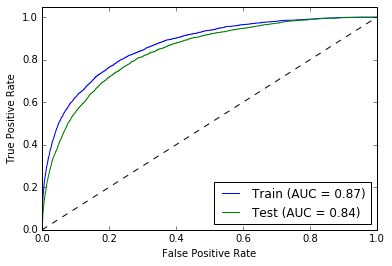

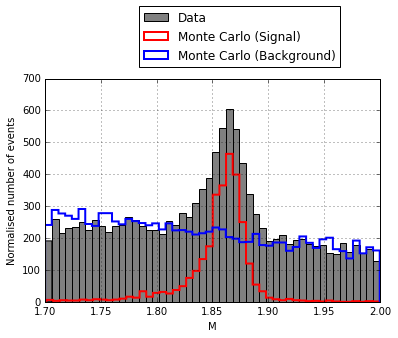

'Signal To Noise -14.86 -25.93'

In [78]:
import sklearn.ensemble
bdt = sklearn.ensemble.GradientBoostingClassifier()
bdt.fit(train[features], train[target].values.ravel())
evaluate_classifier(bdt)

## Exercise 2

### 2.1

Which method is the best? Are the methods overfitted?

### 2.2

Try to optimize the hyper-parameters of three simple methods shown above.
You can get an overview of the available parameters of each classifier by executing 

> lda?
>
> qda?
>
> bdt?


### 2.3

Try to add more features by adding them to the list named features.
What happens if you add kinematic quantities of the daughter particles like
"p0", "p1", "p2" and "daughterAngle01", "daughterAngle02"?

## Expert Only

The following exercise requires knowledge about the SciPy stack and machine learning.
It is meant for students which prior knowledge in machine learning.
Have fun :-)


### Correcting for Data / MC differences

It is possible to correct differences in the data and MC using multivariate classifiers.
You train a classifer, which distinguishes data and MC.
The output of the classifier can be interpreted as the probability of a event to be "data" if drawn from a ensemble "data + mc": p = data / (data + mc)
Next you can assign each Monte Carlo event a probability to be data: w = data / mc.
If you use w as a weight in a training signal against background you effectively corrected for all differences between data and MC the classifier is able to distinguish.

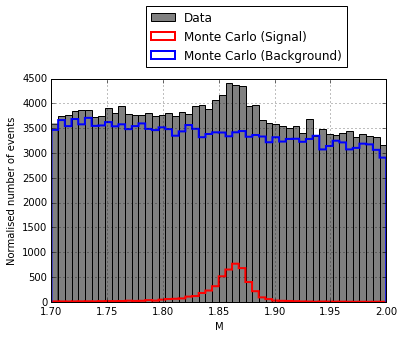

In [80]:
reweight = sklearn.ensemble.GradientBoostingClassifier()
reweight.fit(pd.concat([mc[features], data[features]]), np.r_[np.zeros(len(mc)), np.ones(len(data))])
p = reweight.predict_proba(mc[features])[:, 1]
mc['w'] = p / (1-p)
train, test = mc[len(mc)//2:], mc[:len(mc)//2]
simple_plot('M')

Now we train our BDT as usual, but we use the weights we calculated from the data vs MC BDT output!

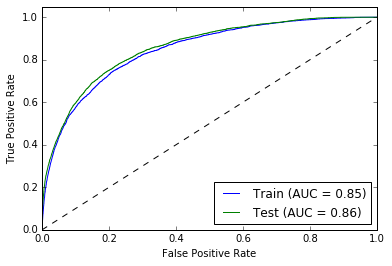

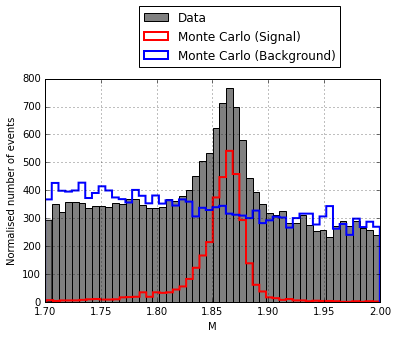

'Signal To Noise -14.86 -23.64'

In [81]:
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(train[features], train[target].values.ravel(), sample_weight=train_w)
evaluate_classifier(clf)

## Exercise 3

### 3.1

Is the performance of the classifier with reweighting better?

### 3.2

Which features contribute the most to the classification?